# Mapping images using the homography transformation

### Overview
This notebook shows how we can use the homography transformation for mapping pixels between two images. Here, we will transform an image seen in perspective into its fronto-parallel rectified view. The view-rectification process is summarized in Figure 1. 

<img src="rectificationProcess.jpg" alt="rectification process" style="zoom:70%;" />

**Figure 1**: Image rectification using the homography transformation. The input is an image of a planar object viewed under  perspective projection. The process calculates the homography transformation that maps the input image to the output shape (i.e., model shape). The model shape is a rectangle with the same size or proportions as the planar object. The pixel coordinates are mapped by the homography transformation and the their colors are transferred to the resulting image using image warping. 

## Main steps
The two mains steps of the rectification process are:
1. Estimate the homography transformation from a set of pairs of corresponding features between the input shape and the destination (model) shape. 
2. Use the estimated homography matrix to warp the input image into the destination shape. 

The two main algorithm steps are: 
$$
\begin{align}
  \Phi &\gets {\tt estimateHomography(}\,x_1,y_1,\dots,x_N,y_N,u_1,v_1,\dots,u_N,v_N \,{\tt )}\notag\\
  {\tt rectifiedImage} &\gets {\tt warpImage(inputImage}, \Phi{\tt )}\notag\\
\end{align}
$$

Here, $\left\{x_1,y_1,\dots,x_N,y_N\right\}$ are the coordinates of non-colinear features detected on the image of the object (i.e., image points), and $\left\{u_1,v_1,\dots,u_N,v_N\right\}$ are the coordinates of the corresponding features on the planar object (i.e., model points).

## The homography transformation (image-capture interpretation)

### Geometry

Consider a camera centered at a point $C\in \mathbb{R}^3$ and pointed at a rectangular object lying on a plane in the scene (Figure 2). Here, the world-coordinate frame $\{{\bf u},{\bf v},{\bf w}\}$ has been placed at one of the corners of the planar object for convinience. The depth axis ${\bf w}$ points downwards. In the diagram in Figure 2, the camera is translated along the negative side of ${\bf w}$ (i.e., facing the rectangle from above). The camera's coordinate frame is given by $\{{\bf u}_c,{\bf v}_c,{\bf w}_c\}$.

<img src="./geometry01.jpg" alt="geometry01" style="zoom:30%;" />

**Figure 2**: Camera is translated along the negative direction of the ${\bf w}$ axis. The imaging geometry is governed by a homography transformation. 

If the camera moves slightly to the left (i.e., towards the v-axis) and turns a bit about the u-axis while facing the rectangle (i.e., the camera is both translated and rotated w.r.t. world-coordinate frame) then the geometric transformation of the image is still a homography transformation albeit a different one. 

<img src="geometry02.jpg" alt="geometry02" style="zoom:30%;" />

**Figure 3**: Camera is rotated and then translated. The imaging geometry is governed by a homography transformation. The homography transformation is different for every pose of the camera.

### Examples

This type of image-capture scenario occurs in many practical situations (Figure 4). 

![examples](examples.jpg)

**Figure 4**: Plane-to-plane transformations in practical scenarios. When planes in a 3-D scene are viewed through a camera, the image of the scene planes and the image are related by a homography transformation. 

### The equation of the homography transformation

The homography transformation maps a point ${\bf w} = \left(u,v\right)^\mathsf{T}$ on the object to a corresponding point ${\bf x} = \left(x,y\right)^\mathsf{T}$ on the image as follows:

$$
\begin{align} 
   x =  \frac{\phi_{11}u_i +  \phi_{12}v_i + \phi_{13}}
                   {\phi_{31}u_i +  \phi_{32}v_i + \phi_{33}} 
 \,\,\,\,\,\,\,\, \text{and}\,\,\,\,\,\,\,\,
   y =  \frac{\phi_{21}u_i +  \phi_{22}v_i + \phi_{23}}
                   {\phi_{31}u_i +  \phi_{32}v_i + \phi_{33}}. 
   \tag{1}
 \end{align}
$$

This transformation is non-linear with respect to the parameters $\phi$. When using homogeneous coordinates, we can write the transformation in matrix form as follows: 

$$
\begin{align} 
   \lambda 
   \begin{bmatrix}
       x_i \\
       y_i \\
       1 
   \end{bmatrix}
   =  
   \begin{bmatrix}
       \phi_{11} & \phi_{12} & \phi_{13} \\
       \phi_{21} & \phi_{22} & \phi_{23} \\
       \phi_{31} & \phi_{32} & \phi_{33} \\
   \end{bmatrix}
   \begin{bmatrix}
       u_i \\
       v_i \\
       1 
   \end{bmatrix},
   \tag{2}
 \end{align}
$$
or in short: 
$$
\begin{align} 
   {\bf \tilde{x}} =  \Phi {\bf \tilde{w}}.
      \tag{3}
 \end{align}
$$

### Estimating the parameters of the homography transformation 

To estimate the parameters of the homography transformation, we re-arrange the above linear system to form of a system of linear equations in terms of the parameters $\phi_{ij}$. After re-arranging the linear system, the resulting system can be of the form $A\phi = {\bf b}$ or  $A\phi = {\bf 0}$. The form $A\phi = {\bf 0}$ is given by: 
$$
\begin{align} 
   \begin{bmatrix}
       0    &    0 & 0 & -u_1 & -v_1 & -1  &   y_1 u_1 &   y_1 v_1 &   y_1 \\  
       u_1 & v_1 & 1 &      0 &     0 &   0  & -x_1 u_1 & -x_1 v_1 & -x_1\\
       \vdots & \vdots & \vdots &      \vdots &     \vdots &   \vdots  &
       \vdots & \vdots & \vdots\\
       0    &    0 & 0 & -u_I & -v_I & -1  &   y_I u_I &   y_I v_I &   y_I \\  
       u_I & v_I & 1 &      0 &     0 &   0  & -x_I u_I & -x_I v_I & -x_I 
   \end{bmatrix}
   \begin{bmatrix}
       \phi_{11} \\
       \phi_{12} \\
       \phi_{13} \\
       \phi_{21} \\
       \phi_{22} \\
       \phi_{23} \\
       \phi_{31} \\
       \phi_{32} \\
       \phi_{33}
   \end{bmatrix}
   = {\bf 0}.
   \tag{4}
 \end{align}
$$



 To solve this equation for the unknown parameters, we calculate the singular-value decomposition of the system matrix, i.e., $A = ULV^T$, and take the last column of matrix $V$ as the approximate solution for $\phi$. While this solution is usually fine for many applications, it can often be further refined by solving the following minimization problem: 

$$
\begin{align} 
   \hat{\Phi} &=  \arg_{\Phi}\min 
                      \left[
                         \sum_{i=1}^{I}
                         \left(x_i - \frac{\phi_{11}u_i +  \phi_{12}v_i + \phi_{13}}
                                             {\phi_{31}u_i +  \phi_{32}v_i + \phi_{33}} 
                          \right)^2
                          + 
                         \left(y_i - \frac{\phi_{21}u_i +  \phi_{22}v_i + \phi_{23}}
                                             {\phi_{31}u_i +  \phi_{32}v_i + \phi_{33}} 
                          \right)^2
                  \right], 
   \tag{5}
 \end{align}
$$

which can be solved by a number of optimization methods (e.g., gradient descent, Newton's method). Here, the initial guess of the non-linear optimization method is the solution obtained from the linear system of equations.  

### Solution using the OpenCV library

In [1]:
import numpy as np
import cv2 as cv
from  matplotlib import pyplot as plt
from scipy.optimize import fsolve, root

import io
import PIL
import requests

#%matplotlib inline

#### Model points (model shape)
In order to rectify the perspective image of the planar object, we need to have a description of the shape of the object when seen from the top or fronto-parallel viewpoint. This shape is usually the original shape of the object (e.g., a rectangle or a square). In the example shown in this notebook, the object is the cover of a book and we will choose a square shape to represent the shape of the object. The shape is given by the coordinates of the corners of the book cover. We will choose the following coordinates: $(u_i,v_i) = \{(0,0),(1000,0),(1000,1000),(0,1000)\}$. Since these features describe our model of the object, we call them model points.   

In [7]:
# Model corners (features detected on the model)
modelCorners = np.float32([[0,0],[1000,0],[1000,1000],[0,1000]])
modelCorners = modelCorners.T;
print("Model points =\n", modelCorners)

Model points =
 [[   0. 1000. 1000.    0.]
 [   0.    0. 1000. 1000.]]


#### Input image
We need an image that shows the planar object. We also need a description of the object in the image. This description is given by a set of features that are corresponding to the features in the model shape. The feature correspondence must be one-to-one. Wrong correspondences will result in wrong results. 

In [2]:
# Image to be warped 
image_response = requests.get('https://raw.githubusercontent.com/eraldoribeiro/Homography-Python-Nonlinear-Optimization/main/stone.png')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

(1106, 1135, 3)


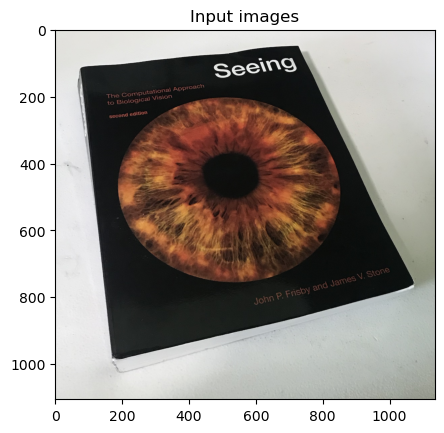

In [3]:
print(im.shape)
plt.imshow(im)
plt.title('Input images')
plt.show()

#### Feature points on the image
The image features in this example are the coordinates of the corners of the book cover. These coordinates are detected using a feature detector or manually. 

In [4]:
# Image features (corners)
imageCorners = np.float32([[80,112],[734,46],[1082,766],[176,990]])
imageCorners = imageCorners.T;
print("Image corners =\n", imageCorners)

Image corners =
 [[  80.  734. 1082.  176.]
 [ 112.   46.  766.  990.]]


Text(0.5, 1.0, 'Corner points')

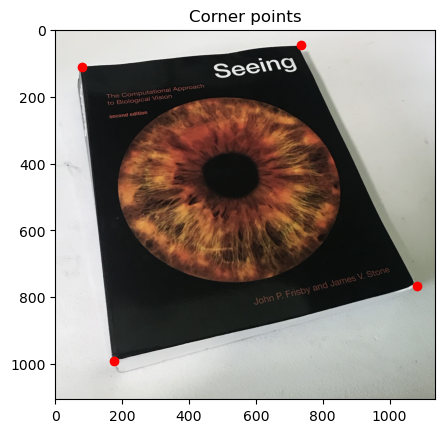

In [5]:
# Display corners on image
fig, ax = plt.subplots()
ax.imshow(im)
ax.plot(imageCorners[0,:], imageCorners[1,:], 'ro', linewidth=10)
plt.title('Corner points')

#### Estimate the homography transformation matrix
Now that we have the model coordinates, the features coordinates, and the image, we can solve the linear system of equations to obtain the homography matrix. When using OpenCV, the estimation is done usign the `getPerspectiveTransform()` function.

In [8]:
# Using the OpenCV functions 
# Function cv.getPerspectiveTransform expects row vectors, not column vectors
Phi = cv.getPerspectiveTransform(imageCorners.T,modelCorners.T)
print("Homography (Phi) matrix = \n", Phi)

Homography (Phi) matrix = 
 [[ 1.42885683e+00 -1.56230359e-01 -9.68107459e+01]
 [ 1.77685507e-01  1.76070185e+00 -2.11413447e+02]
 [-1.12112704e-04  5.88571580e-04  1.00000000e+00]]


#### Warp the image (rectification)
With the Phi matrix at hand, we warp the pixels by transfering them from the perspective image to the model shape. In OpenCV, this is done by the `warpPerspective()` function. 

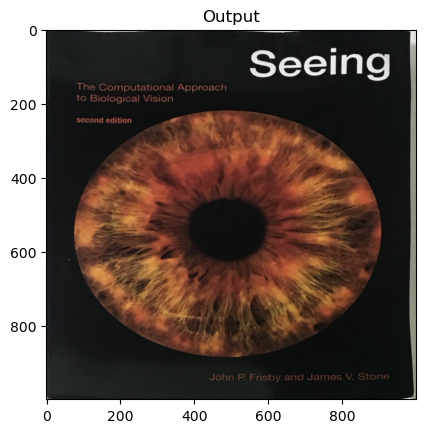

In [9]:
dstImage = cv.warpPerspective(im,Phi,(1000,1000))
plt.imshow(dstImage)
plt.title('Output')
plt.show()

### Explict solution using SVD and non-linear optimization 

In [10]:
# Model coordinates 
u = modelCorners[0,:]
v = modelCorners[1,:]

In [11]:
# Image coordinates
x = imageCorners[0,:]
y = imageCorners[1,:]

#### Build the linear system to solve for the $\Phi$ parameters
$$
\begin{align} 
   \underbrace{\begin{bmatrix}
       0    &    0 & 0 & -u_1 & -v_1 & -1  &   y_1 u_1 &   y_1 v_1 &   y_1 \\  
       u_1 & v_1 & 1 &      0 &     0 &   0  & -x_1 u_1 & -x_1 v_1 & -x_1\\
       \vdots & \vdots & \vdots &      \vdots &     \vdots &   \vdots  &
       \vdots & \vdots & \vdots\\
       0    &    0 & 0 & -u_I & -v_I & -1  &   y_I u_I &   y_I v_I &   y_I \\  
       u_I & v_I & 1 &      0 &     0 &   0  & -x_I u_I & -x_I v_I & -x_I 
   \end{bmatrix}}_{A}
   \underbrace{\begin{bmatrix}
       \phi_{11} \\
       \phi_{12} \\
       \phi_{13} \\
       \phi_{21} \\
       \phi_{22} \\
       \phi_{23} \\
       \phi_{31} \\
       \phi_{32} \\
       \phi_{33}
   \end{bmatrix}}_{\boldsymbol{\phi}}
   = {\bf 0}.
   %\label{system}
 \end{align}
$$

In [13]:
# Build the system matrix to solve for the homography
I = 4   # Number of features 
j = 0;
A = np.zeros( (2*I, 9) )
for i in range(0,I):
    A[j    ,:]  = [    0,         0,     0,    -u[i],   -v[i],     -1,    y[i]*u[i],      y[i]*v[i],    y[i] ]
    A[j+1  ,:]  = [  u[i],     v[i],     1,        0,       0,     0,   -x[i]*u[i],     -x[i]*v[i],   -x[i] ]
    j = j + 2 
    
    
np.set_printoptions(formatter={'float': '{: 0.2f}'.format},suppress=True)    
print("A = \n", A)   

A = 
 [[ 0.00  0.00  0.00 -0.00 -0.00 -1.00  0.00  0.00  112.00]
 [ 0.00  0.00  1.00  0.00  0.00  0.00 -0.00 -0.00 -80.00]
 [ 0.00  0.00  0.00 -1000.00 -0.00 -1.00  46000.00  0.00  46.00]
 [ 1000.00  0.00  1.00  0.00  0.00  0.00 -734000.00 -0.00 -734.00]
 [ 0.00  0.00  0.00 -1000.00 -1000.00 -1.00  766000.00  766000.00  766.00]
 [ 1000.00  1000.00  1.00  0.00  0.00  0.00 -1082000.00 -1082000.00
  -1082.00]
 [ 0.00  0.00  0.00 -0.00 -1000.00 -1.00  0.00  990000.00  990.00]
 [ 0.00  1000.00  1.00  0.00  0.00  0.00 -0.00 -176000.00 -176.00]]


#### SVD solution 
Solve this equation for the unknown parameters, we calculate the singular-value decomposition of the system matrix, i.e., $A = ULV^T$,

In [14]:
# SVD of A
U,D,Vt = np.linalg.svd(A)
print("Vt = \n", Vt)

Vt = 
 [[-0.00 -0.00 -0.00 -0.00 -0.00 -0.00  0.66  0.75  0.00]
 [-0.00  0.00 -0.00 -0.00  0.00  0.00  0.75 -0.66 -0.00]
 [ 0.31  0.50  0.00 -0.67 -0.45 -0.00  0.00 -0.00  0.00]
 [ 0.23 -0.70 -0.00 -0.58  0.24 -0.00 -0.00  0.00 -0.26]
 [-0.53 -0.26 -0.00 -0.30 -0.20 -0.00 -0.00 -0.00  0.72]
 [ 0.43 -0.43 -0.00  0.35 -0.70  0.00  0.00 -0.00  0.12]
 [-0.62 -0.09  0.01 -0.04 -0.46  0.01 -0.00  0.00 -0.63]
 [ 0.00  0.00 -0.81 -0.00  0.00  0.58 -0.00  0.00  0.00]
 [ 0.01  0.00  0.58 -0.00  0.00  0.81  0.00 -0.00  0.01]]


and take the last column of matrix $V$ as the approximate solution for $\phi$: 

In [15]:
# Solution is the last column of V
Phi_hat = Vt.T[:,-1]

#### Re-shape the parameters to form the $\Phi$ matrix
Here, we need to re-shape the array solution to the actual $3\times 3$ matrix of the homography transformation. 

In [16]:
# Re-shape into matrix form 
Phi =  np.float32(
        [[ Phi_hat[0],   Phi_hat[1],    Phi_hat[2] ],
        [ Phi_hat[3],   Phi_hat[4],    Phi_hat[5] ],
        [ Phi_hat[6],   Phi_hat[7],    Phi_hat[8] ]]
       )

print("Phi = \n", Phi)

Phi = 
 [[ 0.01  0.00  0.58]
 [-0.00  0.00  0.81]
 [ 0.00 -0.00  0.01]]


#### Warp image using the estimated homography

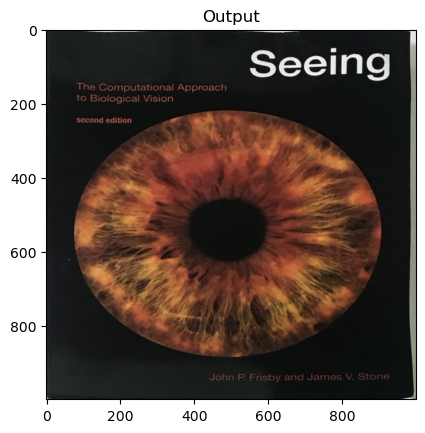

In [17]:
dstImage = cv.warpPerspective(im,np.linalg.inv(Phi),(1000,1000))
plt.imshow(dstImage)
plt.title('Output')
plt.show()

### Refine solution using non-linear optmization
While the linear solution is usually fine for many applications, it can often be refined by solving the following minimization problem:
$$
\begin{align} 
   \hat{\Phi} &=  \arg_{\Phi}\min 
                      \left[
                         \sum_{i=1}^{I}
                         \left(x_i - \frac{\phi_{11}u_i +  \phi_{12}v_i + \phi_{13}}
                                             {\phi_{31}u_i +  \phi_{32}v_i + \phi_{33}} 
                          \right)^2
                          + 
                         \left(y_i - \frac{\phi_{21}u_i +  \phi_{22}v_i + \phi_{23}}
                                             {\phi_{31}u_i +  \phi_{32}v_i + \phi_{33}} 
                          \right)^2                          
                  \right]\notag\\
              &=  \arg_{\Phi}\min 
                      \left[
                         {\tt objectiveFunction} (\phi, {\bf x}, {\bf y}, {\bf u}, {\bf v})                         
                  \right]. 
  %     \label{nonlinearcostfunction}
 \end{align}
$$

To perform the non-linear optimization, we need to implement the objective function.

In [18]:
def objectiveFunction (phi, x, y, u, v):

    I = x.shape[0]
    
    sum_squares = 0.0

    for i in range(0,I):
        # Denominator is common to both x and y produced by model.
        d = phi[6] * u[i] + phi[7] * v[i] + phi[8]

        # Numerator of x from model
        n1 = phi[0] * u[i] + phi[1] * v[i] + phi[2]
        x_model = n1 / d

        # Numerator of y from model
        n2 = phi[3] * u[i] + phi[4] * v[i] + phi[5]
        y_model = n2 / d

    #    print(x_model,x[i])
    #    print(y_model,y[i])

        # Squared norm
        squared_norm = ( x[i] - x_model )**2 +  ( y[i] - y_model )**2        

        # Sum of squared norms
        sum_squares = sum_squares + squared_norm

    return sum_squares 

We provide the homography from the linear estimation as the initial guess for the non-linear solver:

In [22]:
Phi_guess = Phi_hat

The next step is to call the non-linear solver that will try to further refine initial estimate and hopefully provide a better solution to the homography. 

In [23]:
import scipy

out = scipy.optimize.minimize(objectiveFunction,x0=Phi_guess, args=(x, y, u, v),options={'disp': True})

         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 302
         Gradient evaluations: 29


/opt/anaconda3/envs/ar_python/lib/python3.13/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [24]:
print(out.x)


[ 0.01  0.00  0.58 -0.00  0.00  0.81  0.00 -0.00  0.01]


In [25]:
Phi_refined = np.reshape(out.x, (3,3))
Phi_refined

array([[ 0.01,  0.00,  0.58],
       [-0.00,  0.00,  0.81],
       [ 0.00, -0.00,  0.01]])

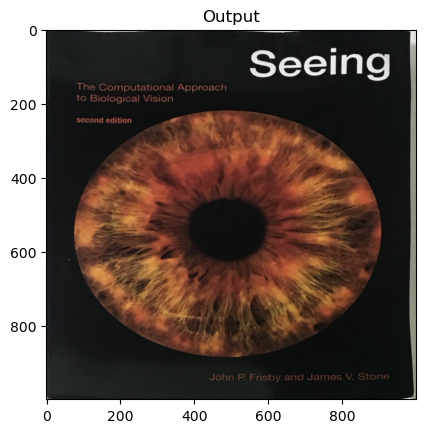

In [26]:
dstImage = cv.warpPerspective(im,np.linalg.inv(Phi_refined),(1000,1000))
plt.imshow(dstImage),
plt.title('Output')
plt.show()

## Example using a Gradio UI for picking image features

In [34]:
!pip install -qq gradio

In [35]:

##---------------------------------------------------
#         Gradio interface as a function
##---------------------------------------------------

def launch_point_picker(my_image):

    # --- Single-image point picker using notebook variable `my_image` ---
    import gradio as gr
    from PIL import Image, ImageDraw
    import numpy as np
    import threading, json, os, io

    # Data
    points_store = []
    app = None
    SELECTED_POINTS = None

    def _to_pil_from_numpy(arr: np.ndarray) -> Image.Image:
        arr = np.asarray(arr)
        # channel-first -> channel-last
        if arr.ndim == 3 and arr.shape[0] in (1,3,4) and arr.shape[-1] not in (1,3,4):
            arr = np.transpose(arr, (1,2,0))
        if np.issubdtype(arr.dtype, np.floating):
            # scale floats in [0,1] to [0,255]
            arr = (np.clip(arr, 0.0, 1.0) * 255.0).round().astype(np.uint8)
        elif arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        # Choose mode
        if arr.ndim == 2:
            return Image.fromarray(arr, mode="L")
        if arr.ndim == 3 and arr.shape[2] == 3:
            return Image.fromarray(arr, mode="RGB")
        if arr.ndim == 3 and arr.shape[2] == 4:
            return Image.fromarray(arr, mode="RGBA")
        if arr.ndim == 3 and arr.shape[2] == 1:
            return Image.fromarray(arr[:,:,0], mode="L")
        raise ValueError(f"Unsupported array shape: {arr.shape}")

    def _to_pil(img):
        if isinstance(img, Image.Image):
            return img
        if isinstance(img, np.ndarray):
            return _to_pil_from_numpy(img)
        raise gr.Error("Set `my_image` to a PIL image or NumPy array before launching.")

    def _draw_points(base_img: Image.Image, pts, radius=5):
        img = base_img.copy().convert("RGB")
        d = ImageDraw.Draw(img)
        for (x, y) in pts:
            d.ellipse([x-radius, y-radius, x+radius, y+radius], outline=(255,0,0), width=2)
        return img

    # Prepare base image from notebook variable
    # if 'my_image' not in globals():
        # raise RuntimeError("Please define `my_image` (PIL image or NumPy array) before running this cell.")
    # base_pil = _to_pil(globals()['my_image'])
    base_pil = _to_pil(my_image)

    def _refresh_numpy():
        """Return current preview (base + points) as numpy for Gradio."""
        return np.array(_draw_points(base_pil, points_store))

    def on_click(evt: gr.SelectData):
        # Get coordinates robustly
        x = y = None
        if hasattr(evt, "index") and evt.index is not None:
            try: x, y = evt.index
            except: pass
        if (x is None or y is None) and hasattr(evt, "x") and hasattr(evt, "y"):
            x, y = evt.x, evt.y
        if x is None or y is None:
            return gr.update(), json.dumps(points_store)

        # Clamp to image bounds
        w, h = base_pil.size
        x = int(max(0, min(w-1, x)))
        y = int(max(0, min(h-1, y)))

        points_store.append([x, y])
        return _refresh_numpy(), json.dumps(points_store)

    def undo_last():
        if points_store:
            points_store.pop()
        return _refresh_numpy(), json.dumps(points_store)

    def clear_points():
        points_store.clear()
        return np.array(base_pil), "[]"

    def done_btn_click():
        """Save to notebook var `selected_points` and close the app."""
        global SELECTED_POINTS
        SELECTED_POINTS = [list(p) for p in points_store]
        try:
            ip = get_ipython()
            if ip is not None:
                ip.user_ns['selected_points'] = SELECTED_POINTS
        except Exception:
            pass
        threading.Thread(target=lambda: app.close(), daemon=True).start()
        return f"✅ Saved {len(SELECTED_POINTS)} points to `selected_points`. Closing…"

    with gr.Blocks(title="Point Picker (single image)") as demo:
        gr.Markdown("**Click on the image to add points.** Use Undo / Clear as needed, then press **Done**.")
        img = gr.Image(
            value=np.array(base_pil), label="Image (click to add points)",
            type="numpy", interactive=True, sources=[]  # sources=[] disables uploads
        )
        with gr.Row():
            undo_btn = gr.Button("↩️ Undo")
            clear_btn = gr.Button("🧹 Clear")
            done_btn = gr.Button("✅ Done", variant="primary")
        pts_text = gr.Textbox(label="Points (JSON)", value="[]", interactive=False)
        status = gr.Markdown("")

        # One image used for both input and output
        img.select(on_click, inputs=None, outputs=[img, pts_text])
        undo_btn.click(lambda: undo_last(), outputs=[img, pts_text])
        clear_btn.click(lambda: clear_points(), outputs=[img, pts_text])
        done_btn.click(done_btn_click, outputs=[status])


        app = demo.launch(inline=True, prevent_thread_lock=True)
        return app



In [38]:
# Using your rgb from PyTorch3D (float in [0,1])
# my_image = (np.clip(im, 0, 1) * 255).astype(np.uint8)  # HxWx3, RGB


# my_image can be a PIL.Image or a NumPy array (H,W[,C])
from PIL import Image
my_image = Image.open("stone.png")

selected_points = []

app = launch_point_picker(my_image)   # launches inline, non-blocking

# ... later, after clicking points and pressing "Done":
print(selected_points)  # list of [x, y] pixel coordinates

# Optional: close programmatically (if you didn't hit Done)
# app.close()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


[]


In [42]:

# Image features (corners)
imageCorners = np.float32(np.array(selected_points))
imageCorners = imageCorners.T;
print("Image corners =\n", imageCorners)

Image corners =
 [[ 78.00  726.00  1069.00  169.00]
 [ 114.00  50.00  757.00  983.00]]


In [43]:
# Using the OpenCV functions 
# Function cv.getPerspectiveTransform expects row vectors, not column vectors
Phi = cv.getPerspectiveTransform(imageCorners.T,modelCorners.T)
print("Homography (Phi) matrix = \n", Phi)

Homography (Phi) matrix = 
 [[ 1.44 -0.15 -95.09]
 [ 0.18  1.79 -218.40]
 [-0.00  0.00  1.00]]


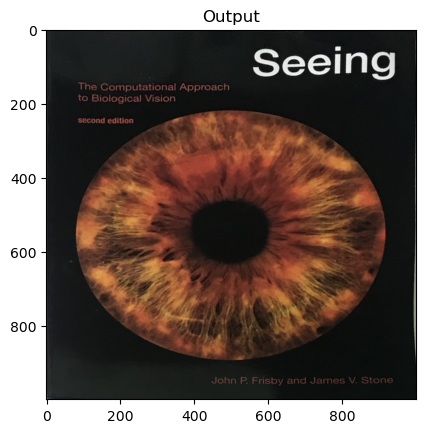

In [44]:
# Warp image using the homography
dstImage = cv.warpPerspective(im,Phi,(1000,1000))
plt.imshow(dstImage)
plt.title('Output')
plt.show()

## Conclusion
In these notes, we calculated the homography transformation from a set of 4 points detected on two images. The model features are set based on the shape we want to have after the transformation. The image features are pixel coordinates from the image of the object. 

We used a system of linear equations in matrix form $A\phi = {\bf 0}$ that was then solved for the homography parameters by calculating the SVD of the system matrix, i.e.,  $A = ULV^T$, and take the last column of matrix $V$ as the approximate solution for $\phi$. This solution was then passed as the guess value to a non-linear optimization function that further refines the homography parameters. 